# Data Reading

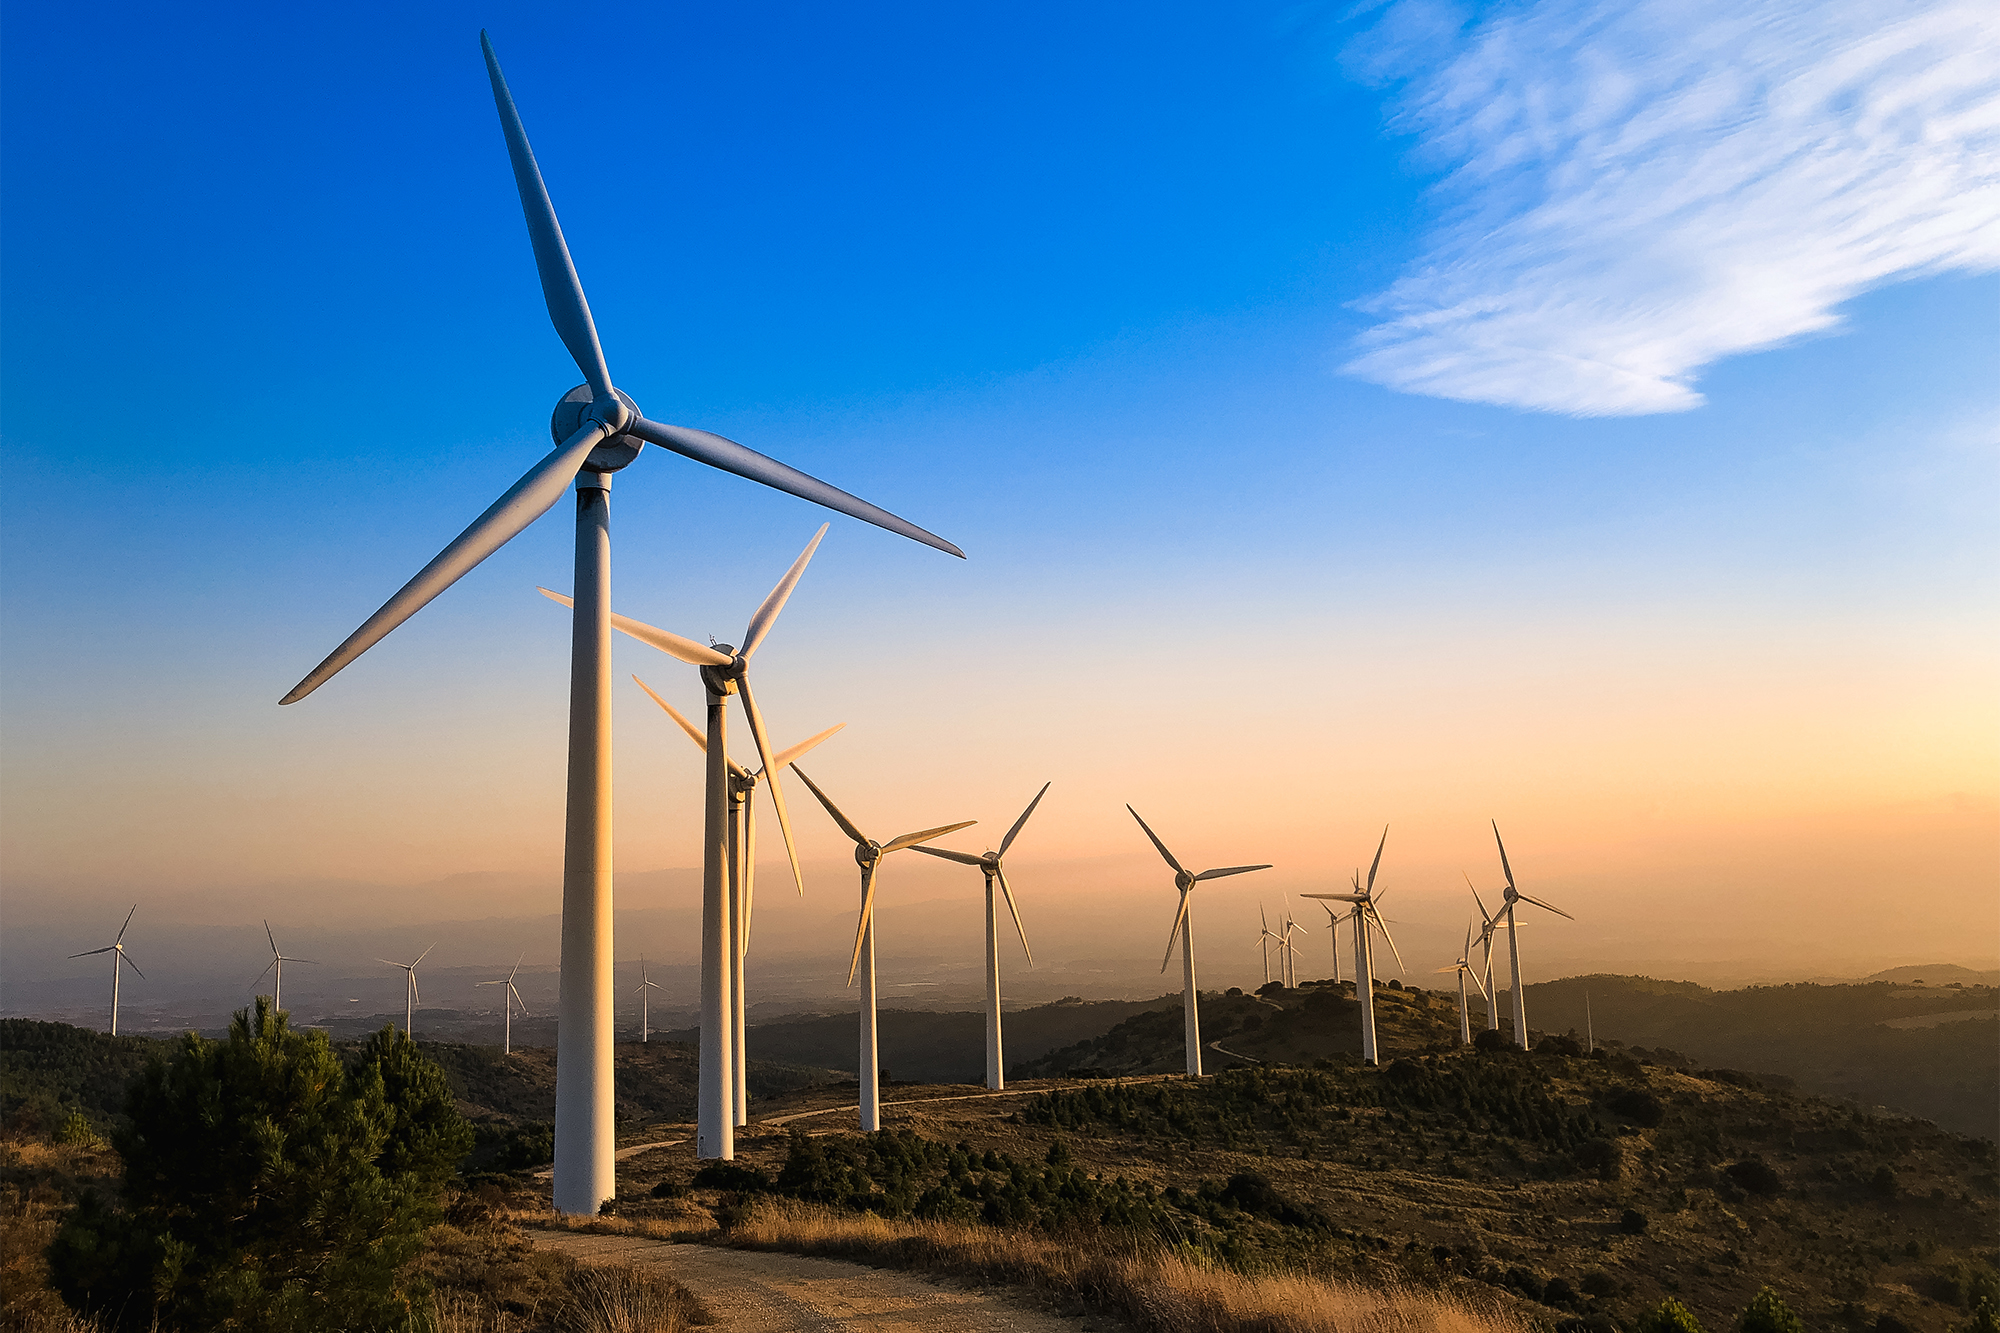

*   Date/Time (for 10 minutes intervals)
*   LV ActivePower (kW): The power generated by the turbine for that moment
*   Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
*   
Theoretical_Power_Curve (KWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
*   Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import matplotlib.cm as cm
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
data=pd.read_csv('D:\Download\wind_power_dataset\T1.csv')
data

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0      01 01 2018 00:00           380.047791          5.311336   
1      01 01 2018 00:10           453.769196          5.672167   
2      01 01 2018 00:20           306.376587          5.216037   
3      01 01 2018 00:30           419.645905          5.659674   
4      01 01 2018 00:40           380.650696          5.577941   
...                 ...                  ...               ...   
50525  31 12 2018 23:10          2963.980957         11.404030   
50526  31 12 2018 23:20          1684.353027          7.332648   
50527  31 12 2018 23:30          2201.106934          8.435358   
50528  31 12 2018 23:40          2515.694092          9.421366   
50529  31 12 2018 23:50          2820.466064          9.979332   

       Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                         416.328908          259.994904  
1                         519.917511          268.641113  
2                         390.900016          272.564789  
3                         516.127569          271.258087  
4                         491.702972          265.674286  
...                              ...                 ...  
50525                    3397.190793           80.502724  
50526                    1173.055771           84.062599  
50527                    1788.284755           84.742500  
50528                    2418.382503           84.297913  
50529                    2779.184096           82.274620  

[50530 rows x 5 columns]

In [ ]:
data.rename(columns={'Date/Time':'datetime','LV ActivePower (kW)':'active_power_kw','Theoretical_Power_Curve (KWh)':'theoretical_power_curve_kwh',"Wind Speed (m/s)":"wind_speed_m_s","Wind Direction (°)":"wind_direction_degree"},
                inplace=True)
data.head()

datetime  active_power_kw  wind_speed_m_s  \
0  01 01 2018 00:00       380.047791        5.311336   
1  01 01 2018 00:10       453.769196        5.672167   
2  01 01 2018 00:20       306.376587        5.216037   
3  01 01 2018 00:30       419.645905        5.659674   
4  01 01 2018 00:40       380.650696        5.577941   

   theoretical_power_curve_kwh  wind_direction_degree  
0                   416.328908             259.994904  
1                   519.917511             268.641113  
2                   390.900016             272.564789  
3                   516.127569             271.258087  
4                   491.702972             265.674286

In [ ]:
data.isnull().sum()

datetime                       0
active_power_kw                0
wind_speed_m_s                 0
theoretical_power_curve_kwh    0
wind_direction_degree          0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datetime                     50530 non-null  object 
 1   active_power_kw              50530 non-null  float64
 2   wind_speed_m_s               50530 non-null  float64
 3   theoretical_power_curve_kwh  50530 non-null  float64
 4   wind_direction_degree        50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [ ]:
# Convert column to datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Set date column as index
data.set_index('datetime', inplace=True)

data

active_power_kw  wind_speed_m_s  \
datetime                                               
2018-01-01 00:00:00       380.047791        5.311336   
2018-01-01 00:10:00       453.769196        5.672167   
2018-01-01 00:20:00       306.376587        5.216037   
2018-01-01 00:30:00       419.645905        5.659674   
2018-01-01 00:40:00       380.650696        5.577941   
...                              ...             ...   
2018-12-31 23:10:00      2963.980957       11.404030   
2018-12-31 23:20:00      1684.353027        7.332648   
2018-12-31 23:30:00      2201.106934        8.435358   
2018-12-31 23:40:00      2515.694092        9.421366   
2018-12-31 23:50:00      2820.466064        9.979332   

                     theoretical_power_curve_kwh  wind_direction_degree  
datetime                                                                 
2018-01-01 00:00:00                   416.328908             259.994904  
2018-01-01 00:10:00                   519.917511             268.641113  
2018-01-01 00:20:00                   390.900016             272.564789  
2018-01-01 00:30:00                   516.127569             271.258087  
2018-01-01 00:40:00                   491.702972             265.674286  
...                                          ...                    ...  
2018-12-31 23:10:00                  3397.190793              80.502724  
2018-12-31 23:20:00                  1173.055771              84.062599  
2018-12-31 23:30:00                  1788.284755              84.742500  
2018-12-31 23:40:00                  2418.382503              84.297913  
2018-12-31 23:50:00                  2779.184096              82.274620  

[50530 rows x 4 columns]

# Data Analysis

Hourly

In [ ]:
# Get hours from datetime
dates = data.index
hours = [date.hour for date in dates]
data['hour'] = hours

data

active_power_kw  wind_speed_m_s  \
datetime                                               
2018-01-01 00:00:00       380.047791        5.311336   
2018-01-01 00:10:00       453.769196        5.672167   
2018-01-01 00:20:00       306.376587        5.216037   
2018-01-01 00:30:00       419.645905        5.659674   
2018-01-01 00:40:00       380.650696        5.577941   
...                              ...             ...   
2018-12-31 23:10:00      2963.980957       11.404030   
2018-12-31 23:20:00      1684.353027        7.332648   
2018-12-31 23:30:00      2201.106934        8.435358   
2018-12-31 23:40:00      2515.694092        9.421366   
2018-12-31 23:50:00      2820.466064        9.979332   

                     theoretical_power_curve_kwh  wind_direction_degree  hour  
datetime                                                                       
2018-01-01 00:00:00                   416.328908             259.994904     0  
2018-01-01 00:10:00                   519.917511             268.641113     0  
2018-01-01 00:20:00                   390.900016             272.564789     0  
2018-01-01 00:30:00                   516.127569             271.258087     0  
2018-01-01 00:40:00                   491.702972             265.674286     0  
...                                          ...                    ...   ...  
2018-12-31 23:10:00                  3397.190793              80.502724    23  
2018-12-31 23:20:00                  1173.055771              84.062599    23  
2018-12-31 23:30:00                  1788.284755              84.742500    23  
2018-12-31 23:40:00                  2418.382503              84.297913    23  
2018-12-31 23:50:00                  2779.184096              82.274620    23  

[50530 rows x 5 columns]

In [ ]:
data['wind_speed_m_s'] = pd.to_numeric(data['wind_speed_m_s'], errors='coerce')


In [ ]:
data['wind_speed_m_s'] = data['wind_speed_m_s'].astype(float)


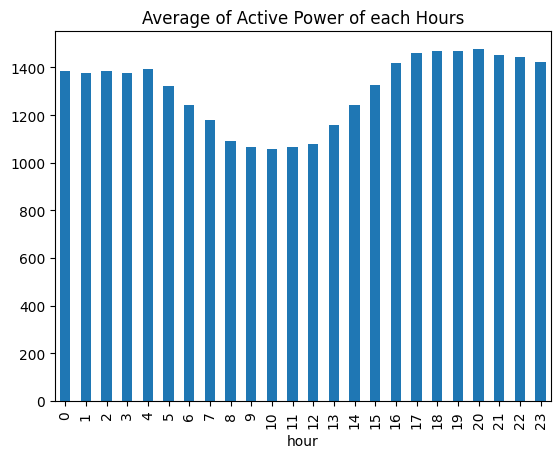

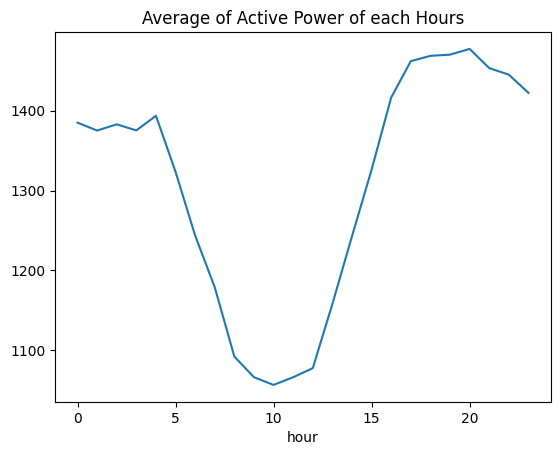

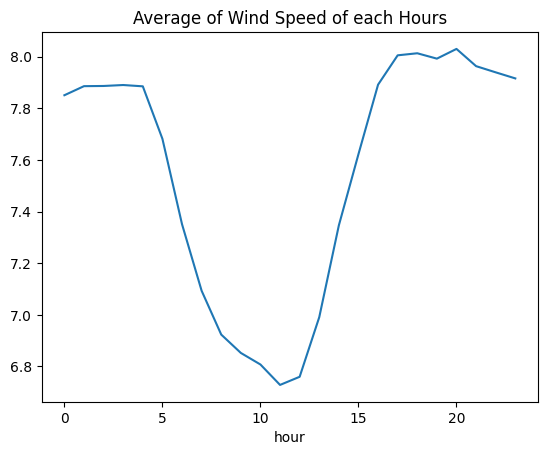

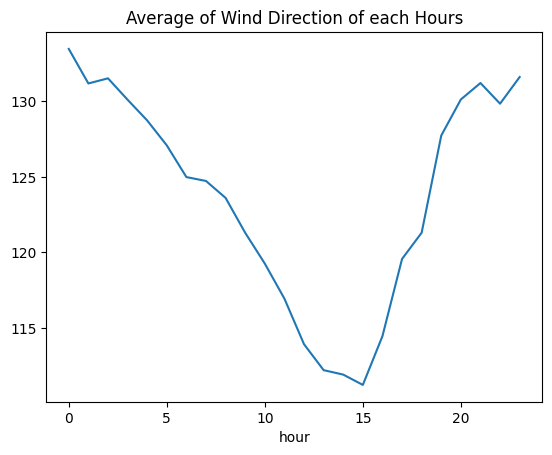

In [ ]:
data.groupby('hour').mean().active_power_kw.plot(kind='bar', title='Average of Active Power of each Hours')
plt.show()

data.groupby('hour').mean().active_power_kw.plot(title='Average of Active Power of each Hours')
plt.show()

data.groupby('hour').mean().wind_speed_m_s.plot(title='Average of Wind Speed of each Hours')
plt.show()

data.groupby('hour').mean().wind_direction_degree.plot(title='Average of Wind Direction of each Hours')
plt.show()

Monthly

In [ ]:
# Get hours from datetime
dates = data.index
months = [date.month for date in dates]
data['month'] = months

data

active_power_kw  wind_speed_m_s  \
datetime                                               
2018-01-01 00:00:00       380.047791        5.311336   
2018-01-01 00:10:00       453.769196        5.672167   
2018-01-01 00:20:00       306.376587        5.216037   
2018-01-01 00:30:00       419.645905        5.659674   
2018-01-01 00:40:00       380.650696        5.577941   
...                              ...             ...   
2018-12-31 23:10:00      2963.980957       11.404030   
2018-12-31 23:20:00      1684.353027        7.332648   
2018-12-31 23:30:00      2201.106934        8.435358   
2018-12-31 23:40:00      2515.694092        9.421366   
2018-12-31 23:50:00      2820.466064        9.979332   

                     theoretical_power_curve_kwh  wind_direction_degree  hour  \
datetime                                                                        
2018-01-01 00:00:00                   416.328908             259.994904     0   
2018-01-01 00:10:00                   519.917511             268.641113     0   
2018-01-01 00:20:00                   390.900016             272.564789     0   
2018-01-01 00:30:00                   516.127569             271.258087     0   
2018-01-01 00:40:00                   491.702972             265.674286     0   
...                                          ...                    ...   ...   
2018-12-31 23:10:00                  3397.190793              80.502724    23   
2018-12-31 23:20:00                  1173.055771              84.062599    23   
2018-12-31 23:30:00                  1788.284755              84.742500    23   
2018-12-31 23:40:00                  2418.382503              84.297913    23   
2018-12-31 23:50:00                  2779.184096              82.274620    23   

                     month  
datetime                    
2018-01-01 00:00:00      1  
2018-01-01 00:10:00      1  
2018-01-01 00:20:00      1  
2018-01-01 00:30:00      1  
2018-01-01 00:40:00      1  
...                    ...  
2018-12-31 23:10:00     12  
2018-12-31 23:20:00     12  
2018-12-31 23:30:00     12  
2018-12-31 23:40:00     12  
2018-12-31 23:50:00     12  

[50530 rows x 6 columns]

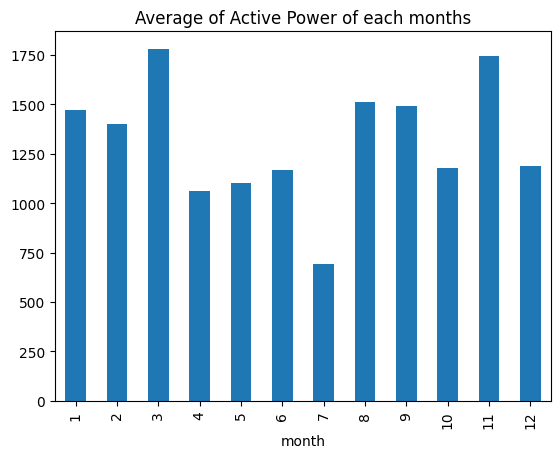

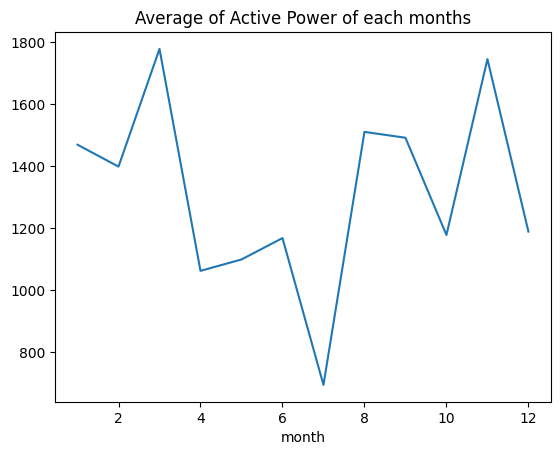

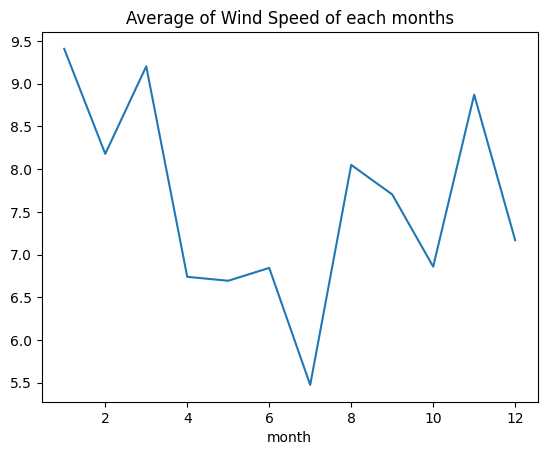

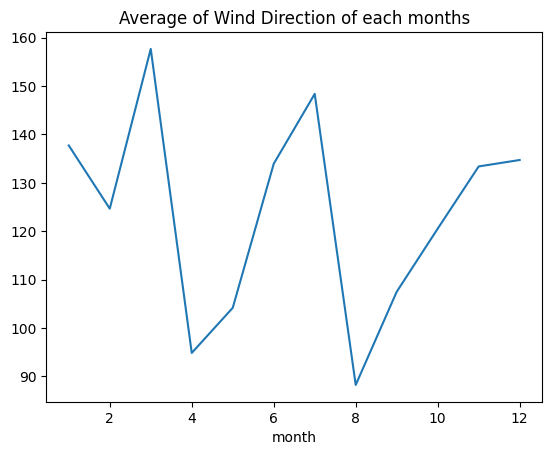

In [ ]:
data.groupby('month').mean().active_power_kw.plot(kind='bar', title='Average of Active Power of each months')
plt.show()

data.groupby('month').mean().active_power_kw.plot(title='Average of Active Power of each months')
plt.show()

data.groupby('month').mean().wind_speed_m_s.plot(title='Average of Wind Speed of each months')
plt.show()

data.groupby('month').mean().wind_direction_degree.plot(title='Average of Wind Direction of each months')
plt.show()

In [ ]:
columns=['active_power_kw', 'wind_speed_m_s', 'theoretical_power_curve_kwh', 'wind_direction_degree', 'hour', 'month']
display(data[columns].corr())

active_power_kw  wind_speed_m_s  \
active_power_kw                     1.000000        0.912774   
wind_speed_m_s                      0.912774        1.000000   
theoretical_power_curve_kwh         0.949918        0.944209   
wind_direction_degree              -0.062702       -0.077188   
hour                                0.036355        0.024754   
month                              -0.013359       -0.074892   

                             theoretical_power_curve_kwh  \
active_power_kw                                 0.949918   
wind_speed_m_s                                  0.944209   
theoretical_power_curve_kwh                     1.000000   
wind_direction_degree                          -0.099076   
hour                                            0.034636   
month                                          -0.055629   

                             wind_direction_degree      hour     month  
active_power_kw                          -0.062702  0.036355 -0.013359  
wind_speed_m_s                           -0.077188  0.024754 -0.074892  
theoretical_power_curve_kwh              -0.099076  0.034636 -0.055629  
wind_direction_degree                     1.000000 -0.015355 -0.022852  
hour                                     -0.015355  1.000000 -0.001024  
month                                    -0.022852 -0.001024  1.000000

We see a correlation between electricity produced and wind speed, which is to be expected.

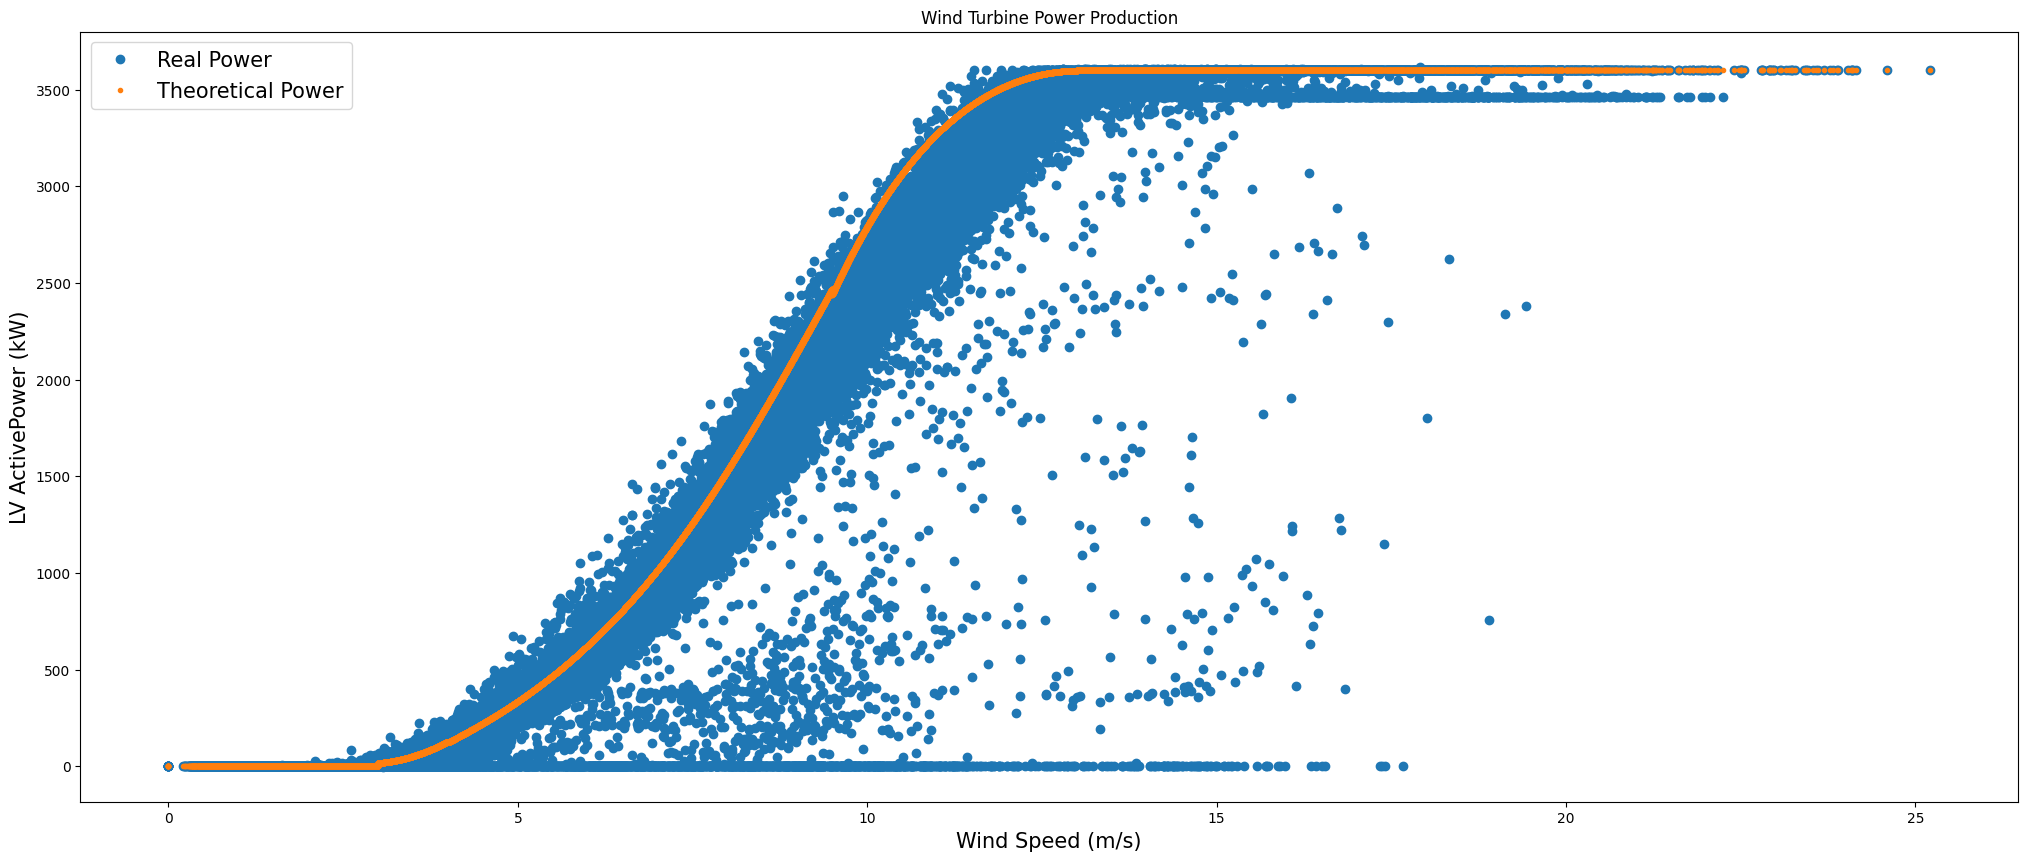

In [ ]:
plt.figure(figsize=(25,10)) 
plt.plot(data['wind_speed_m_s'], data['active_power_kw'], 'o', label='Real Power')
plt.plot(data['wind_speed_m_s'], data['theoretical_power_curve_kwh'], '.', label='Theoretical Power')
plt.xlabel('Wind Speed (m/s)', size=15)
plt.ylabel('LV ActivePower (kW)', size=15)
plt.title('Wind Turbine Power Production')
plt.legend(fontsize=15)
plt.show()

From the graph above we can see the power production reaches near a maximum level after the wind speed reaches 15 m/s.

In [ ]:
# Calculate power loss - difference between the active power generated by the turbine for that moment and the theoretical power values that the turbine generates with that wind speed
data['loss'] = data['theoretical_power_curve_kwh'] - data['active_power_kw']

data

active_power_kw  wind_speed_m_s  \
datetime                                               
2018-01-01 00:00:00       380.047791        5.311336   
2018-01-01 00:10:00       453.769196        5.672167   
2018-01-01 00:20:00       306.376587        5.216037   
2018-01-01 00:30:00       419.645905        5.659674   
2018-01-01 00:40:00       380.650696        5.577941   
...                              ...             ...   
2018-12-31 23:10:00      2963.980957       11.404030   
2018-12-31 23:20:00      1684.353027        7.332648   
2018-12-31 23:30:00      2201.106934        8.435358   
2018-12-31 23:40:00      2515.694092        9.421366   
2018-12-31 23:50:00      2820.466064        9.979332   

                     theoretical_power_curve_kwh  wind_direction_degree  hour  \
datetime                                                                        
2018-01-01 00:00:00                   416.328908             259.994904     0   
2018-01-01 00:10:00                   519.917511             268.641113     0   
2018-01-01 00:20:00                   390.900016             272.564789     0   
2018-01-01 00:30:00                   516.127569             271.258087     0   
2018-01-01 00:40:00                   491.702972             265.674286     0   
...                                          ...                    ...   ...   
2018-12-31 23:10:00                  3397.190793              80.502724    23   
2018-12-31 23:20:00                  1173.055771              84.062599    23   
2018-12-31 23:30:00                  1788.284755              84.742500    23   
2018-12-31 23:40:00                  2418.382503              84.297913    23   
2018-12-31 23:50:00                  2779.184096              82.274620    23   

                     month        loss  
datetime                                
2018-01-01 00:00:00      1   36.281117  
2018-01-01 00:10:00      1   66.148316  
2018-01-01 00:20:00      1   84.523429  
2018-01-01 00:30:00      1   96.481664  
2018-01-01 00:40:00      1  111.052276  
...                    ...         ...  
2018-12-31 23:10:00     12  433.209835  
2018-12-31 23:20:00     12 -511.297256  
2018-12-31 23:30:00     12 -412.822178  
2018-12-31 23:40:00     12  -97.311588  
2018-12-31 23:50:00     12  -41.281968  

[50530 rows x 7 columns]

In [ ]:
def find_mean_speed(x):
  """function for rewriting wind speed for 0.5 intervals"""
  list=[]
  i=0.25
  while i<=25.5:
    list.append(i)
    i+=0.5
  for i in list:
    if x < i:
      x=i-0.25
      return x

In [ ]:
data["mean_wind_speed_m_s"]=data["wind_speed_m_s"].apply(find_mean_speed)
data

active_power_kw  wind_speed_m_s  \
datetime                                               
2018-01-01 00:00:00       380.047791        5.311336   
2018-01-01 00:10:00       453.769196        5.672167   
2018-01-01 00:20:00       306.376587        5.216037   
2018-01-01 00:30:00       419.645905        5.659674   
2018-01-01 00:40:00       380.650696        5.577941   
...                              ...             ...   
2018-12-31 23:10:00      2963.980957       11.404030   
2018-12-31 23:20:00      1684.353027        7.332648   
2018-12-31 23:30:00      2201.106934        8.435358   
2018-12-31 23:40:00      2515.694092        9.421366   
2018-12-31 23:50:00      2820.466064        9.979332   

                     theoretical_power_curve_kwh  wind_direction_degree  hour  \
datetime                                                                        
2018-01-01 00:00:00                   416.328908             259.994904     0   
2018-01-01 00:10:00                   519.917511             268.641113     0   
2018-01-01 00:20:00                   390.900016             272.564789     0   
2018-01-01 00:30:00                   516.127569             271.258087     0   
2018-01-01 00:40:00                   491.702972             265.674286     0   
...                                          ...                    ...   ...   
2018-12-31 23:10:00                  3397.190793              80.502724    23   
2018-12-31 23:20:00                  1173.055771              84.062599    23   
2018-12-31 23:30:00                  1788.284755              84.742500    23   
2018-12-31 23:40:00                  2418.382503              84.297913    23   
2018-12-31 23:50:00                  2779.184096              82.274620    23   

                     month        loss  mean_wind_speed_m_s  
datetime                                                     
2018-01-01 00:00:00      1   36.281117                  5.5  
2018-01-01 00:10:00      1   66.148316                  5.5  
2018-01-01 00:20:00      1   84.523429                  5.0  
2018-01-01 00:30:00      1   96.481664                  5.5  
2018-01-01 00:40:00      1  111.052276                  5.5  
...                    ...         ...                  ...  
2018-12-31 23:10:00     12  433.209835                 11.5  
2018-12-31 23:20:00     12 -511.297256                  7.5  
2018-12-31 23:30:00     12 -412.822178                  8.5  
2018-12-31 23:40:00     12  -97.311588                  9.5  
2018-12-31 23:50:00     12  -41.281968                 10.0  

[50530 rows x 8 columns]

In [ ]:
def mean_direction(x):
    """function to classificate wind direction into 0, 30, 60, ... 360"""
    list=[]
    i=15
    while i<=375:
        list.append(i)
        i+=30
        
    for i in list:
        if x < i:
            x=i-15
            if x==360:
                return 0
            else:
                return x

In [ ]:
data["mean_direction_degree"]=data["wind_direction_degree"].apply(mean_direction)
data

active_power_kw  wind_speed_m_s  \
datetime                                               
2018-01-01 00:00:00       380.047791        5.311336   
2018-01-01 00:10:00       453.769196        5.672167   
2018-01-01 00:20:00       306.376587        5.216037   
2018-01-01 00:30:00       419.645905        5.659674   
2018-01-01 00:40:00       380.650696        5.577941   
...                              ...             ...   
2018-12-31 23:10:00      2963.980957       11.404030   
2018-12-31 23:20:00      1684.353027        7.332648   
2018-12-31 23:30:00      2201.106934        8.435358   
2018-12-31 23:40:00      2515.694092        9.421366   
2018-12-31 23:50:00      2820.466064        9.979332   

                     theoretical_power_curve_kwh  wind_direction_degree  hour  \
datetime                                                                        
2018-01-01 00:00:00                   416.328908             259.994904     0   
2018-01-01 00:10:00                   519.917511             268.641113     0   
2018-01-01 00:20:00                   390.900016             272.564789     0   
2018-01-01 00:30:00                   516.127569             271.258087     0   
2018-01-01 00:40:00                   491.702972             265.674286     0   
...                                          ...                    ...   ...   
2018-12-31 23:10:00                  3397.190793              80.502724    23   
2018-12-31 23:20:00                  1173.055771              84.062599    23   
2018-12-31 23:30:00                  1788.284755              84.742500    23   
2018-12-31 23:40:00                  2418.382503              84.297913    23   
2018-12-31 23:50:00                  2779.184096              82.274620    23   

                     month        loss  mean_wind_speed_m_s  \
datetime                                                      
2018-01-01 00:00:00      1   36.281117                  5.5   
2018-01-01 00:10:00      1   66.148316                  5.5   
2018-01-01 00:20:00      1   84.523429                  5.0   
2018-01-01 00:30:00      1   96.481664                  5.5   
2018-01-01 00:40:00      1  111.052276                  5.5   
...                    ...         ...                  ...   
2018-12-31 23:10:00     12  433.209835                 11.5   
2018-12-31 23:20:00     12 -511.297256                  7.5   
2018-12-31 23:30:00     12 -412.822178                  8.5   
2018-12-31 23:40:00     12  -97.311588                  9.5   
2018-12-31 23:50:00     12  -41.281968                 10.0   

                     mean_direction_degree  
datetime                                    
2018-01-01 00:00:00                    270  
2018-01-01 00:10:00                    270  
2018-01-01 00:20:00                    270  
2018-01-01 00:30:00                    270  
2018-01-01 00:40:00                    270  
...                                    ...  
2018-12-31 23:10:00                     90  
2018-12-31 23:20:00                     90  
2018-12-31 23:30:00                     90  
2018-12-31 23:40:00                     90  
2018-12-31 23:50:00                     90  

[50530 rows x 9 columns]

In [ ]:
def find_direction_compass(x):
    """function to find wind direction"""
    if x==0:
        return "N"
    if x==30:
        return "NNE"
    if x==60:
        return "NEE" 
    if x==90:
        return "E" 
    if x==120:
        return "SEE" 
    if x==150:
        return "SSE" 
    if x==180:
        return "S" 
    if x==210:
        return "SSW" 
    if x==240:
        return "SWW" 
    if x==270:
        return "W" 
    if x==300:
        return "NWW" 
    if x==330:
        return "NNW"

In [ ]:
data["direction_compass"]=data["mean_direction_degree"].apply(find_direction_compass)
data

active_power_kw  wind_speed_m_s  \
datetime                                               
2018-01-01 00:00:00       380.047791        5.311336   
2018-01-01 00:10:00       453.769196        5.672167   
2018-01-01 00:20:00       306.376587        5.216037   
2018-01-01 00:30:00       419.645905        5.659674   
2018-01-01 00:40:00       380.650696        5.577941   
...                              ...             ...   
2018-12-31 23:10:00      2963.980957       11.404030   
2018-12-31 23:20:00      1684.353027        7.332648   
2018-12-31 23:30:00      2201.106934        8.435358   
2018-12-31 23:40:00      2515.694092        9.421366   
2018-12-31 23:50:00      2820.466064        9.979332   

                     theoretical_power_curve_kwh  wind_direction_degree  hour  \
datetime                                                                        
2018-01-01 00:00:00                   416.328908             259.994904     0   
2018-01-01 00:10:00                   519.917511             268.641113     0   
2018-01-01 00:20:00                   390.900016             272.564789     0   
2018-01-01 00:30:00                   516.127569             271.258087     0   
2018-01-01 00:40:00                   491.702972             265.674286     0   
...                                          ...                    ...   ...   
2018-12-31 23:10:00                  3397.190793              80.502724    23   
2018-12-31 23:20:00                  1173.055771              84.062599    23   
2018-12-31 23:30:00                  1788.284755              84.742500    23   
2018-12-31 23:40:00                  2418.382503              84.297913    23   
2018-12-31 23:50:00                  2779.184096              82.274620    23   

                     month        loss  mean_wind_speed_m_s  \
datetime                                                      
2018-01-01 00:00:00      1   36.281117                  5.5   
2018-01-01 00:10:00      1   66.148316                  5.5   
2018-01-01 00:20:00      1   84.523429                  5.0   
2018-01-01 00:30:00      1   96.481664                  5.5   
2018-01-01 00:40:00      1  111.052276                  5.5   
...                    ...         ...                  ...   
2018-12-31 23:10:00     12  433.209835                 11.5   
2018-12-31 23:20:00     12 -511.297256                  7.5   
2018-12-31 23:30:00     12 -412.822178                  8.5   
2018-12-31 23:40:00     12  -97.311588                  9.5   
2018-12-31 23:50:00     12  -41.281968                 10.0   

                     mean_direction_degree direction_compass  
datetime                                                      
2018-01-01 00:00:00                    270                 W  
2018-01-01 00:10:00                    270                 W  
2018-01-01 00:20:00                    270                 W  
2018-01-01 00:30:00                    270                 W  
2018-01-01 00:40:00                    270                 W  
...                                    ...               ...  
2018-12-31 23:10:00                     90                 E  
2018-12-31 23:20:00                     90                 E  
2018-12-31 23:30:00                     90                 E  
2018-12-31 23:40:00                     90                 E  
2018-12-31 23:50:00                     90                 E  

[50530 rows x 10 columns]

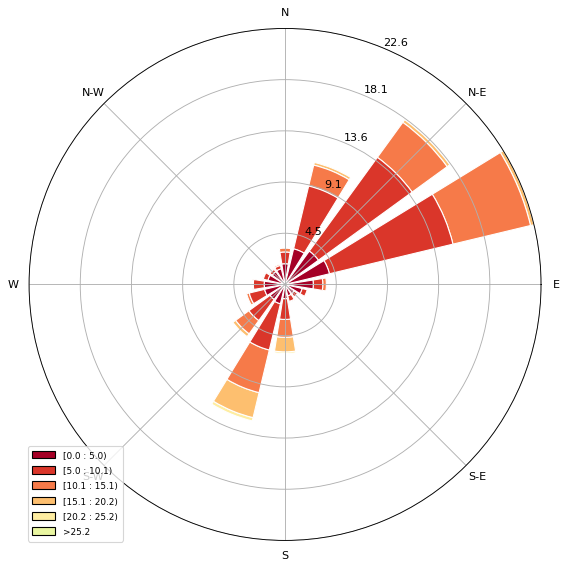

In [ ]:
colors = cm.RdYlGn(np.linspace(0, 1, 10))
ax = WindroseAxes.from_ax()
ax.bar(data['wind_direction_degree'], data['wind_speed_m_s'], normed=True, opening=0.8, edgecolor='white', colors=colors)
ax.set_legend()
plt.show()

Based on the chart, we see that the south and southwest winds have the greatest speed, but these types of winds are not as common as the northeast wind, and the speed of the northeast wind is slightly less than the south winds. 

Text(0, 0.5, 'Wind speed (m/s)')

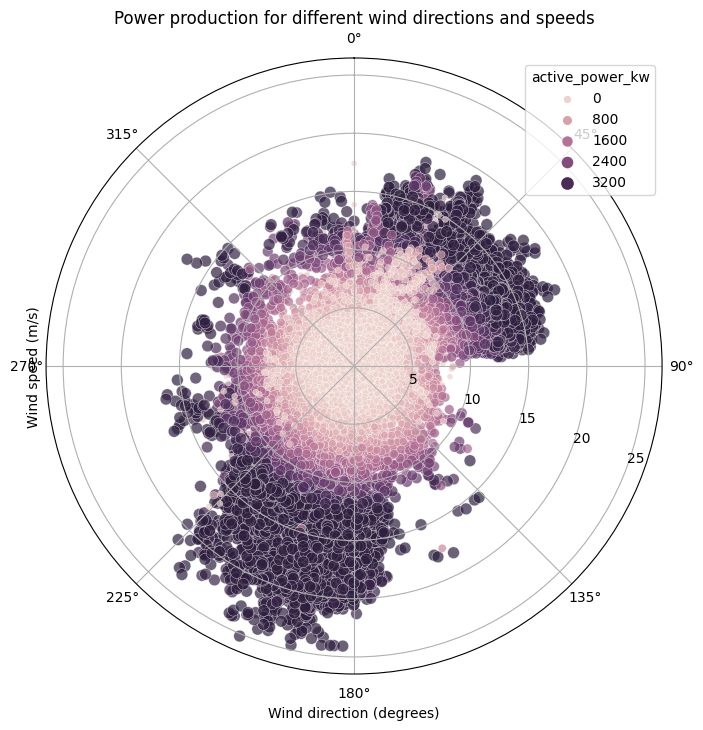

In [ ]:
from math import radians

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# Inside circles are the wind speed and marker color and size represents the amount of power production
sns.scatterplot(x=[radians(x) for x in data['wind_direction_degree']], 
                y=data['wind_speed_m_s'],
                size=data['active_power_kw'],
                hue=data['active_power_kw'],
                alpha=0.7)
# Setting the polar diagram's top represents the North 
ax.set_theta_zero_location('N')
# Setting -1 to start the wind direction clockwise
ax.set_theta_direction(-1)
# Setting wind speed labels in a better position to see
ax.set_rlabel_position(110)
plt.title('Power production for different wind directions and speeds')
plt.xlabel('Wind direction (degrees)')
plt.ylabel('Wind speed (m/s)')


We can see that the wind turbine produces more power if the wind blows from the N-E and S-SW directions

After analyzing the data, we found out that:
1. On average, 6:00 a.m. to 2:00 p.m. produces the least amount of energy in a 24-hour period
2. The 1st fact is due to the fact that it is at this time that the wind blows at a lower speed
3. The most energy is generated in March and November
4. However, the least amount of energy is produced in April, July, October and December
5. There is an understandable correlation that the lowest wind speeds are in the same months as in fact 4
6. The power production reaches near a maximum level after the wind speed reaches 15 m/s
7. The south and southwest winds have the greatest speed
8. The south and southwest types of winds are not as common as the northeast wind, and the speed of the northeast wind is slightly less than the south winds
9. The wind turbine produces more power if the wind blows from the N-E and S-SW directions


# Predictions of different models

## Metrics

Mean Absolute Error

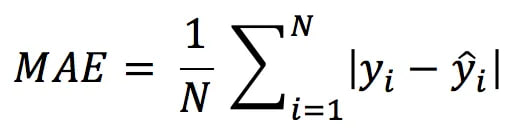

Root Mean Squared Error

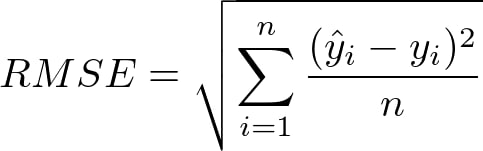

R Squared

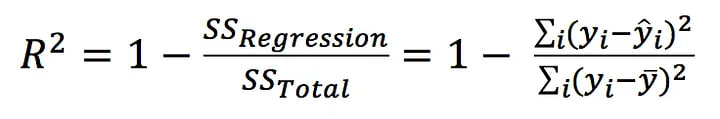

## Select relevant features and split the data into training and testing sets

In [ ]:
ftrain = ['active_power_kw', 'wind_speed_m_s', 'wind_direction_degree', 'hour', 'month', 'mean_wind_speed_m_s', 'mean_direction_degree']

def definedatacolumns():
    data2 = data[ftrain]
    X = data2.drop(columns=['active_power_kw']).values
    y = data2['active_power_kw'].values
    return X, y

## Make predictions on the testing and entire dataset and count R2, MAE and RMSE

In [ ]:
def fit_predict_model(regressor):
    model = regressor
    X, y = definedatacolumns()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 25)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_total = model.predict(X)
    r2 = r2_score(y_test, y_pred)
    print('R2 score on the test:', r2)
    mae = mean_absolute_error(y_test, y_pred)
    print('MAE on the test:', mae)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print('RMSE on the test:', rmse)
    return y_total, y

## Visualize the actual, theoretical and predicted power production

In [ ]:
def visualise_pred_theor_act(y_actual, y_predicted):
    y = y_actual
    y_total = y_predicted
    TP = data['theoretical_power_curve_kwh']
    number = len(data['wind_speed_m_s'])
    aa=[x for x in data['wind_speed_m_s']]
    plt.figure(figsize=(25,10)) 
    plt.plot(aa, y[:number], 'o', label='Real Power')
    plt.plot(aa, y_total[:number], 'x', label='Predicted Power')
    plt.plot(aa, TP[:number], '.', label='theoretical_power_curve (kwh)')
    
    plt.xlabel('wind speed (m/s)', size=15)
    plt.ylabel('Power Production (kw)', size=15)
    plt.title('Wind Turbine Power Production Prediction')
    plt.legend(fontsize=15)
    plt.show()

In [ ]:
data['wind_speed_m_s'] = data['wind_speed_m_s'].fillna(data['wind_speed_m_s'].mean())
data['mean_wind_speed_m_s'] = data['mean_wind_speed_m_s'].fillna(data['mean_wind_speed_m_s'].mean())


In [ ]:
data.isnull().sum()


active_power_kw                0
wind_speed_m_s                 0
theoretical_power_curve_kwh    0
wind_direction_degree          0
hour                           0
month                          0
loss                           0
mean_wind_speed_m_s            0
mean_direction_degree          0
direction_compass              0
dtype: int64

Decision Tree Regressor

R2 score on the test: 0.9288356214224879
MAE on the test: 122.10502287082517
RMSE on the test: 349.22071890452753


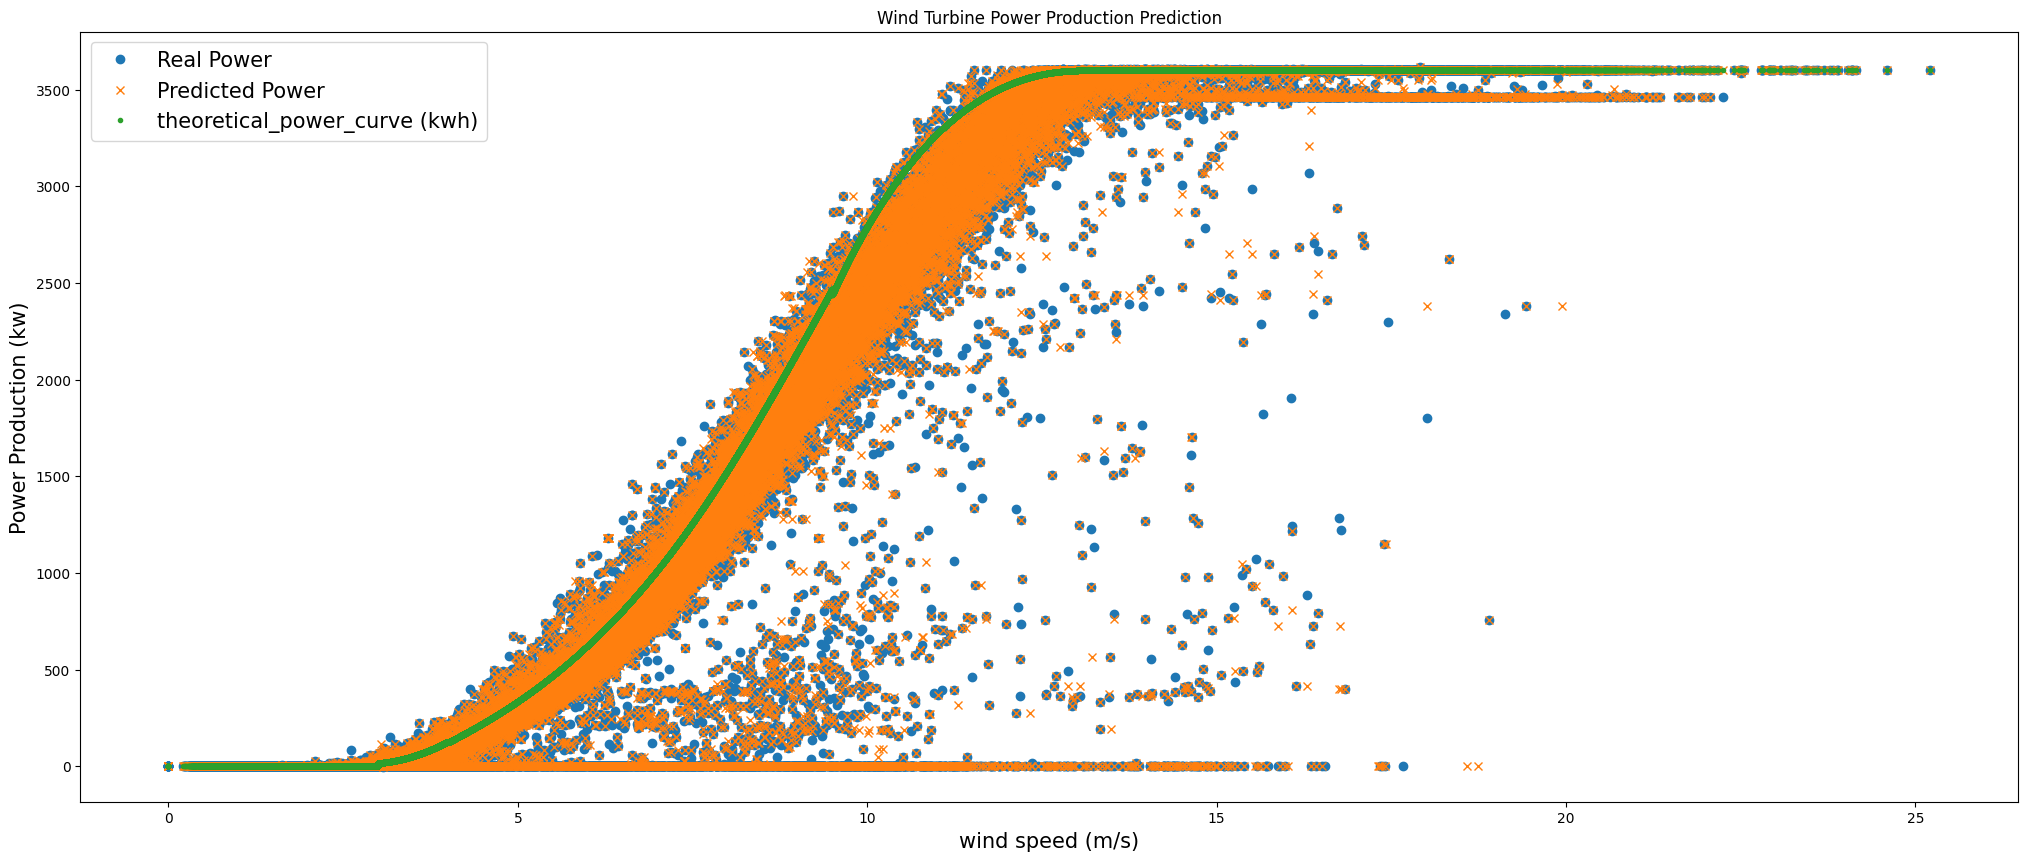

In [ ]:
y_predicted, y_actual = fit_predict_model(DecisionTreeRegressor())
visualise_pred_theor_act(y_actual, y_predicted)

Random Forest Regressor

R2 score on the test: 0.9599019223471442
MAE on the test: 102.84990851812813
RMSE on the test: 262.1382812829049


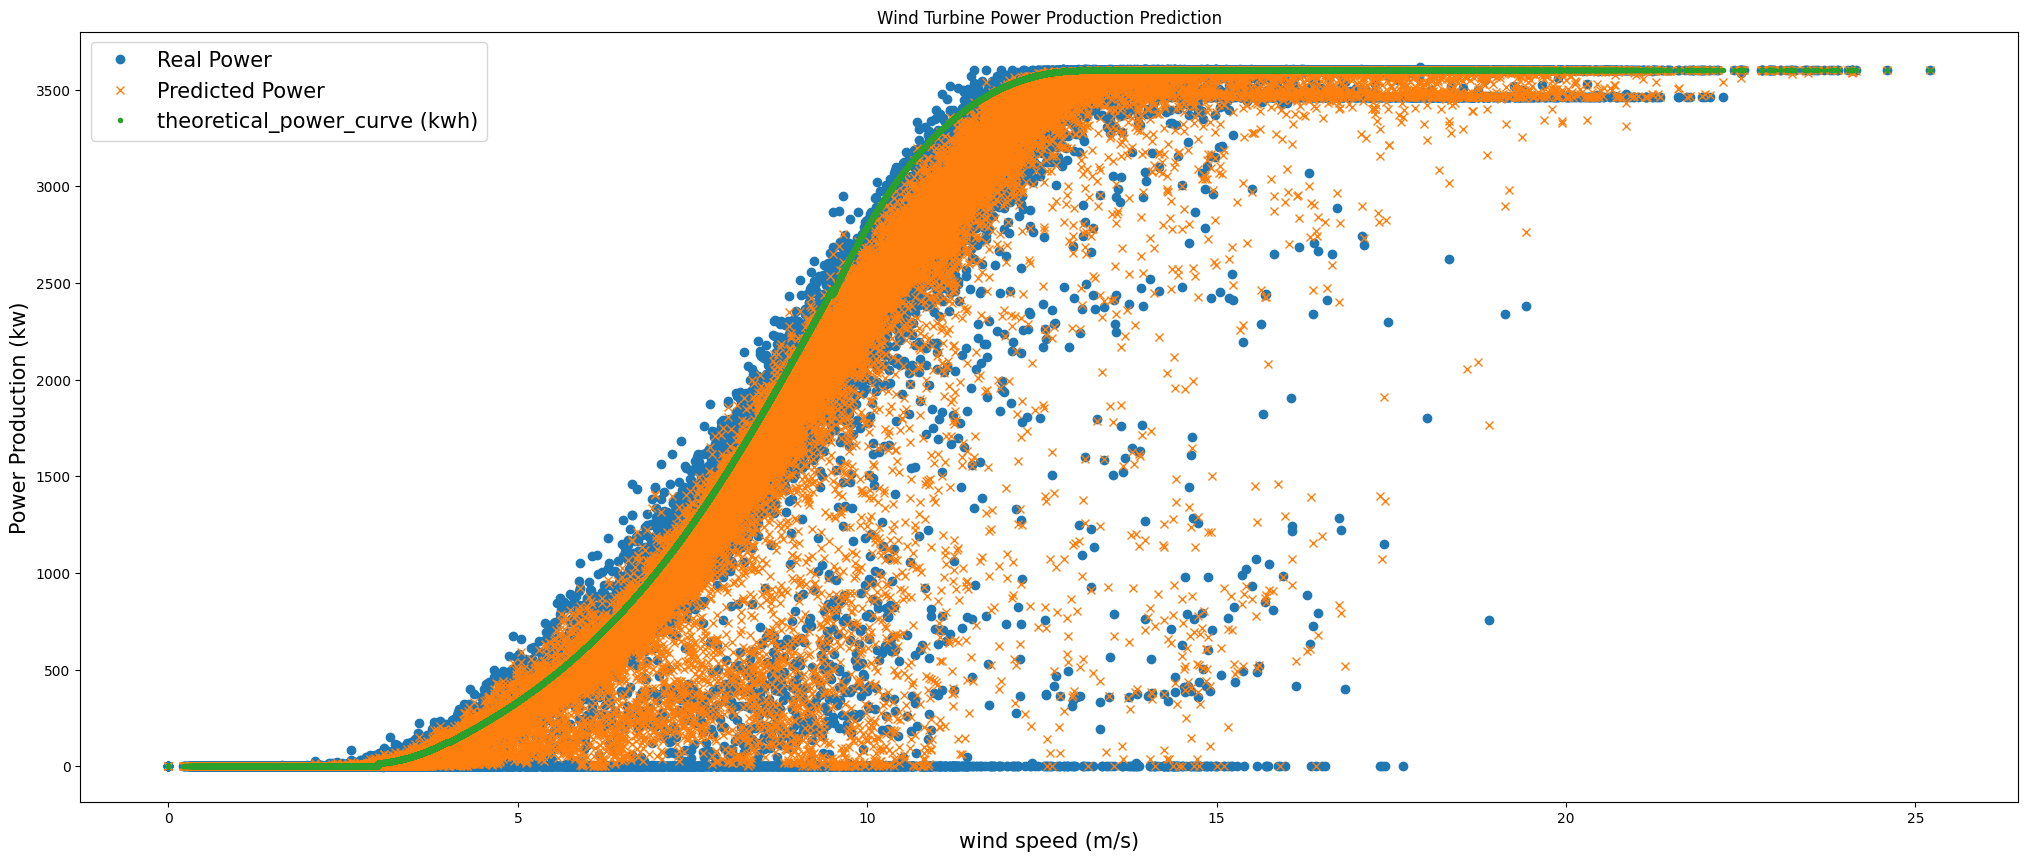

In [ ]:
y_predicted, y_actual = fit_predict_model(RandomForestRegressor())
visualise_pred_theor_act(y_actual, y_predicted)

Extra Trees Regressor

R2 score on the test: 0.9591836129805187
MAE on the test: 101.44073586143129
RMSE on the test: 264.47580700688974


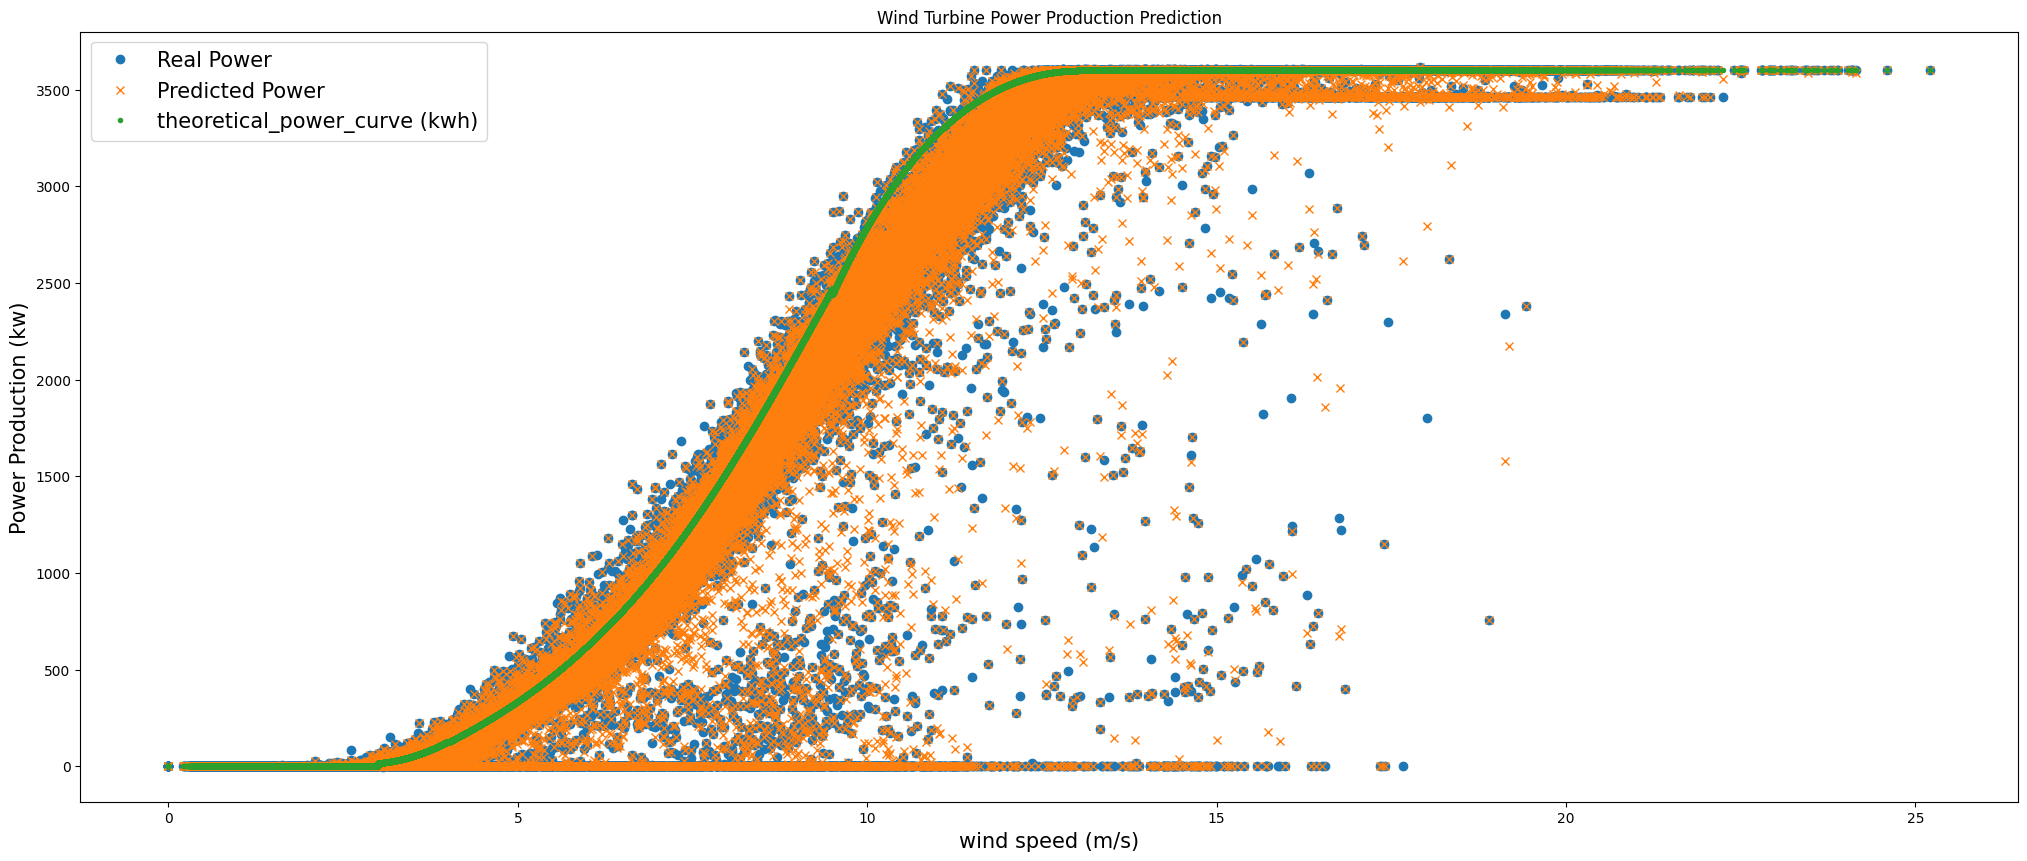

In [ ]:
y_predicted, y_actual = fit_predict_model(ExtraTreesRegressor())
visualise_pred_theor_act(y_actual, y_predicted)

Ada Boost Regressor

R2 score on the test: 0.8571747835971281
MAE on the test: 291.4495589124982
RMSE on the test: 494.7332697778081


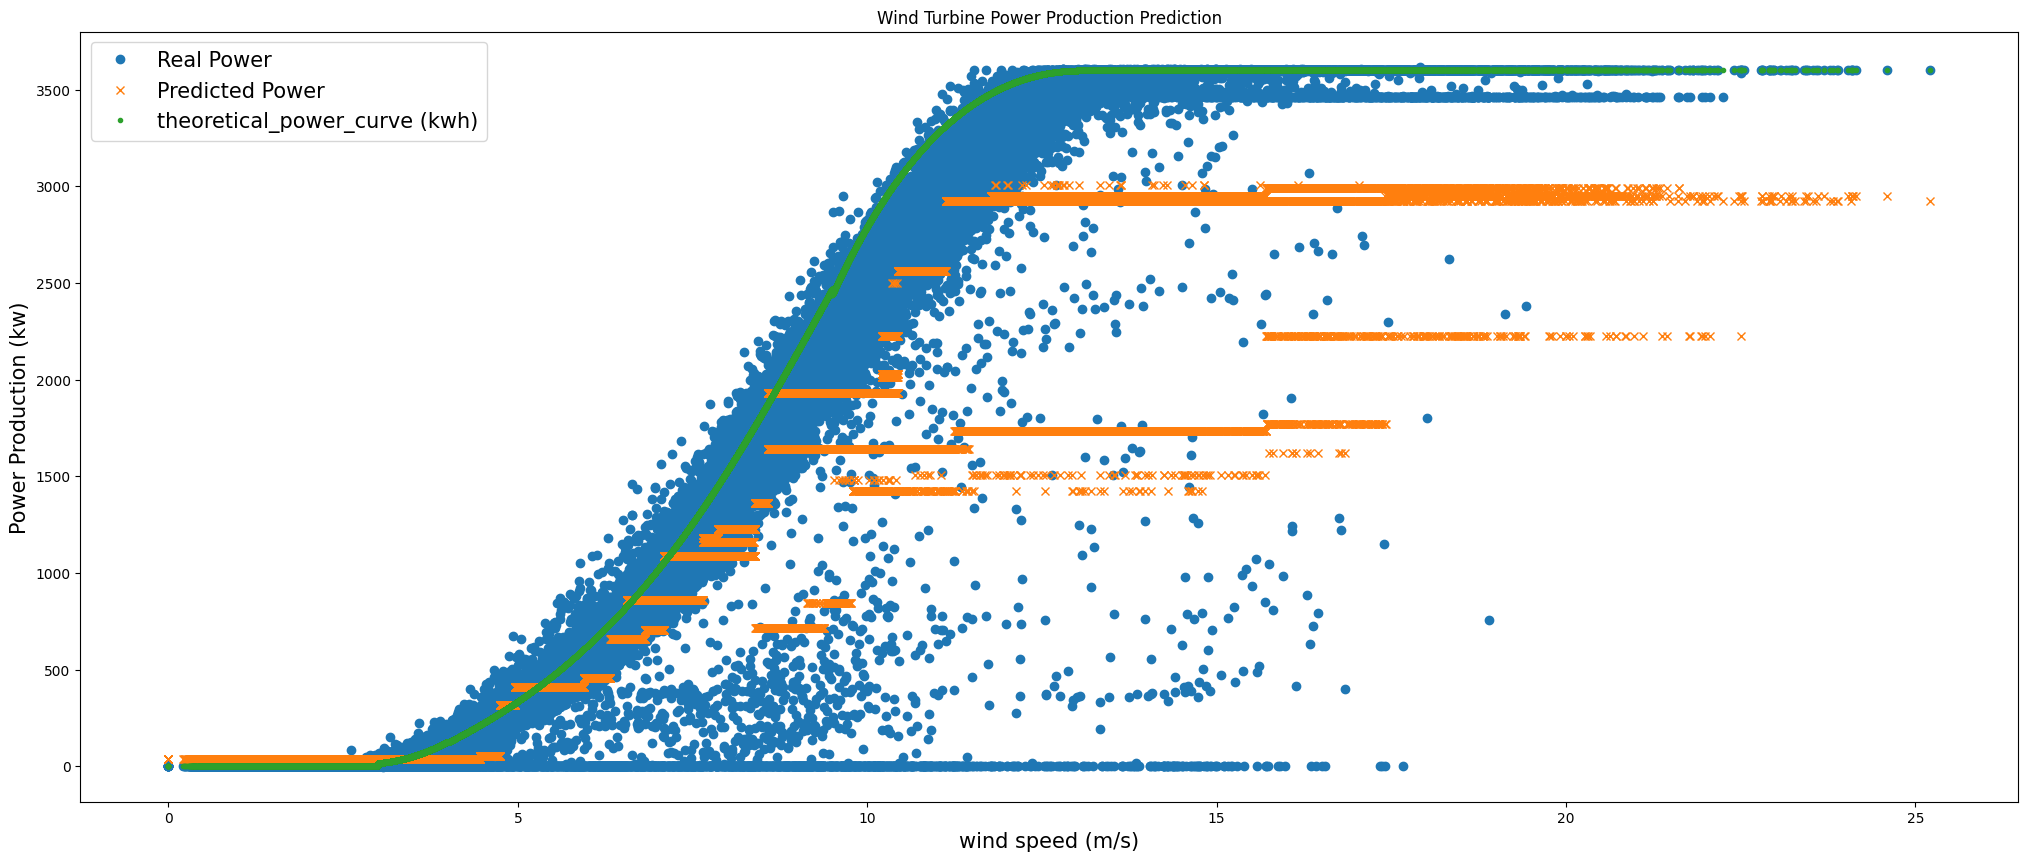

In [ ]:
y_predicted, y_actual = fit_predict_model(AdaBoostRegressor())
visualise_pred_theor_act(y_actual, y_predicted)

Extreme Gradient Boosting Regressor

In [ ]:
# Define the grid of hyperparameters to search over
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.02, 0.05],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1.0, 1.1, 1.2],
    'reg_alpha': [0.1, 0.3, 0.5],
    'reg_lambda': [0.5, 0.7, 0.9],
}

# Create an instance of XGBRegressor
xgb = XGBRegressor()

X, y = definedatacolumns()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=25)

# Create an instance of GridSearchCV
grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print('R2 score on the test:', r2)
print('MAE on the test:', mae)
print('RMSE on the test:', rmse)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

R2 score on the test: 0.953521185140565
MAE on the test: 119.6271311887633
RMSE on the test: 282.22546300455963
Best hyperparameters:  {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1.0, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.9}
Best score:  0.9492887393965246


In [ ]:
# Get the best estimator
best_estimator = grid_search.best_estimator_

# Use the best estimator to predict on the test data
y_pred = best_estimator.predict(X_test)

# Calculate the metrics
r2 = r2_score(y_test, y_pred)
print('R2 score on the test:', r2)

mae = mean_absolute_error(y_test, y_pred)
print('MAE on the test:', mae)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE on the test:', rmse)

R2 score on the test: 0.953521185140565
MAE on the test: 119.6271311887633
RMSE on the test: 282.22546300455963


R2 score on the test: 0.953521185140565
MAE on the test: 119.6271311887633
RMSE on the test: 282.22546300455963


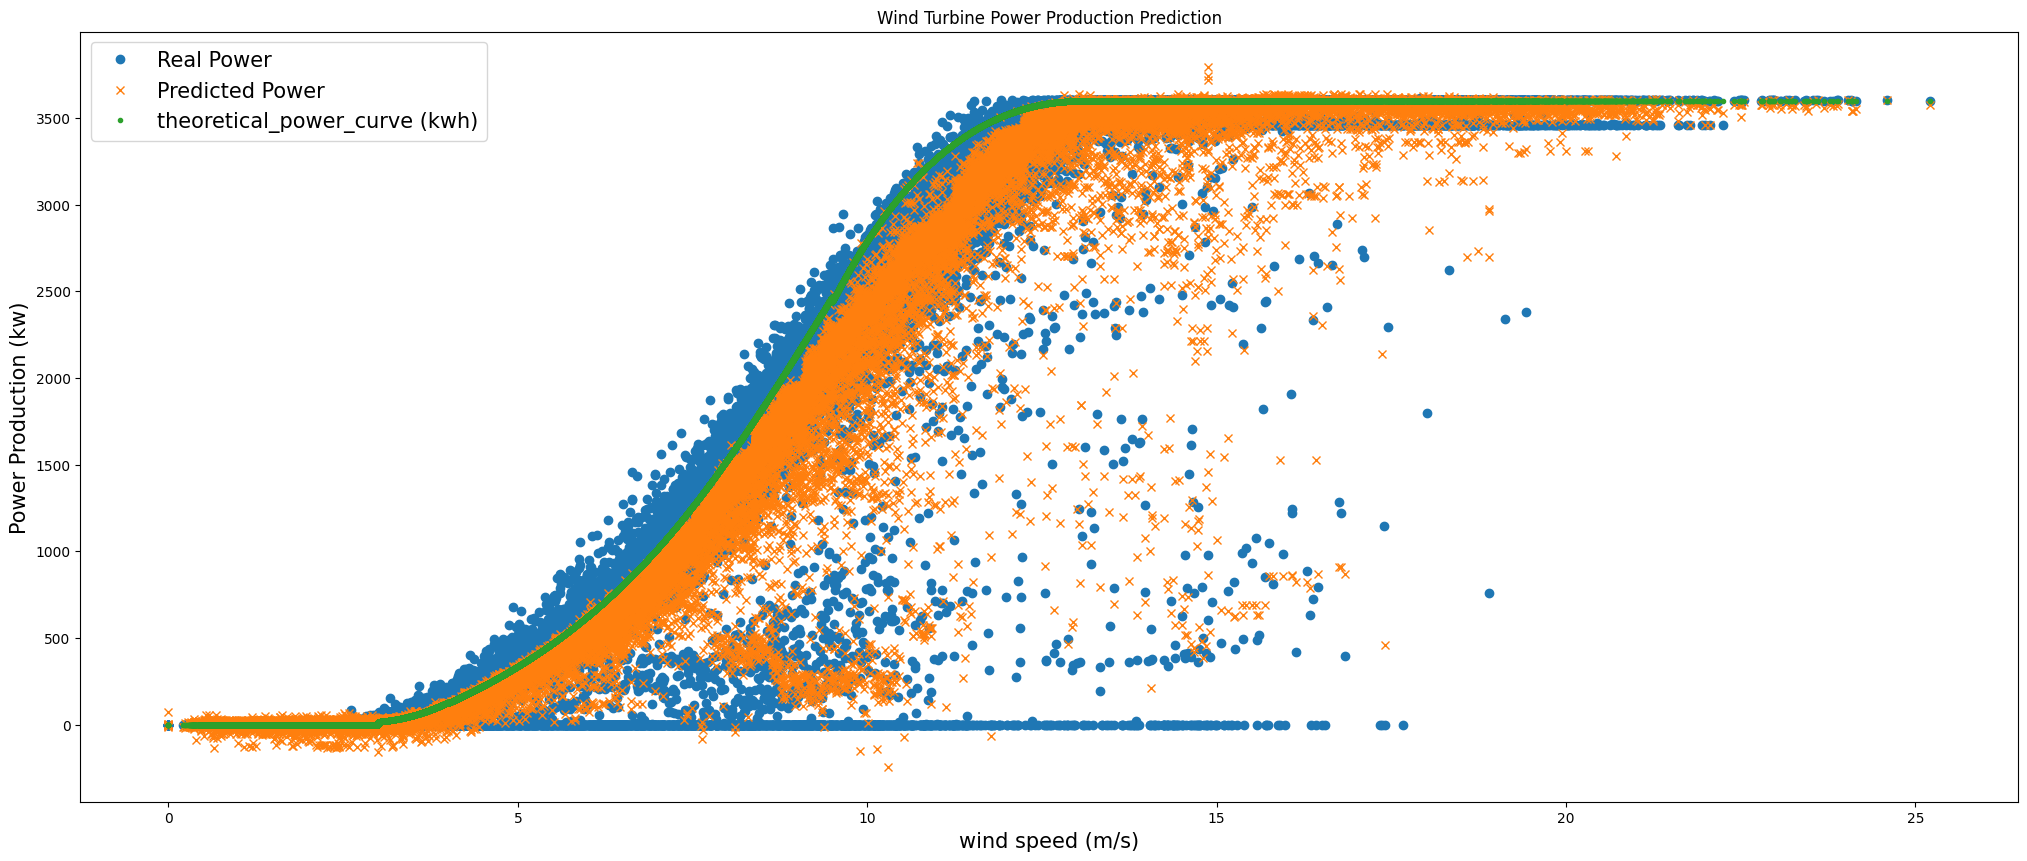

In [ ]:
y_predicted, y_actual = fit_predict_model(XGBRegressor(learning_rate=0.05, max_depth=5, min_child_weight=1.0, n_estimators=200, reg_alpha=0.1, reg_lambda=0.9))
visualise_pred_theor_act(y_actual, y_predicted)

Gradient Boosting Regressor

R2 score on the test: 0.9419123139296377
MAE on the test: 136.94212720538505
RMSE on the test: 315.5082426646852


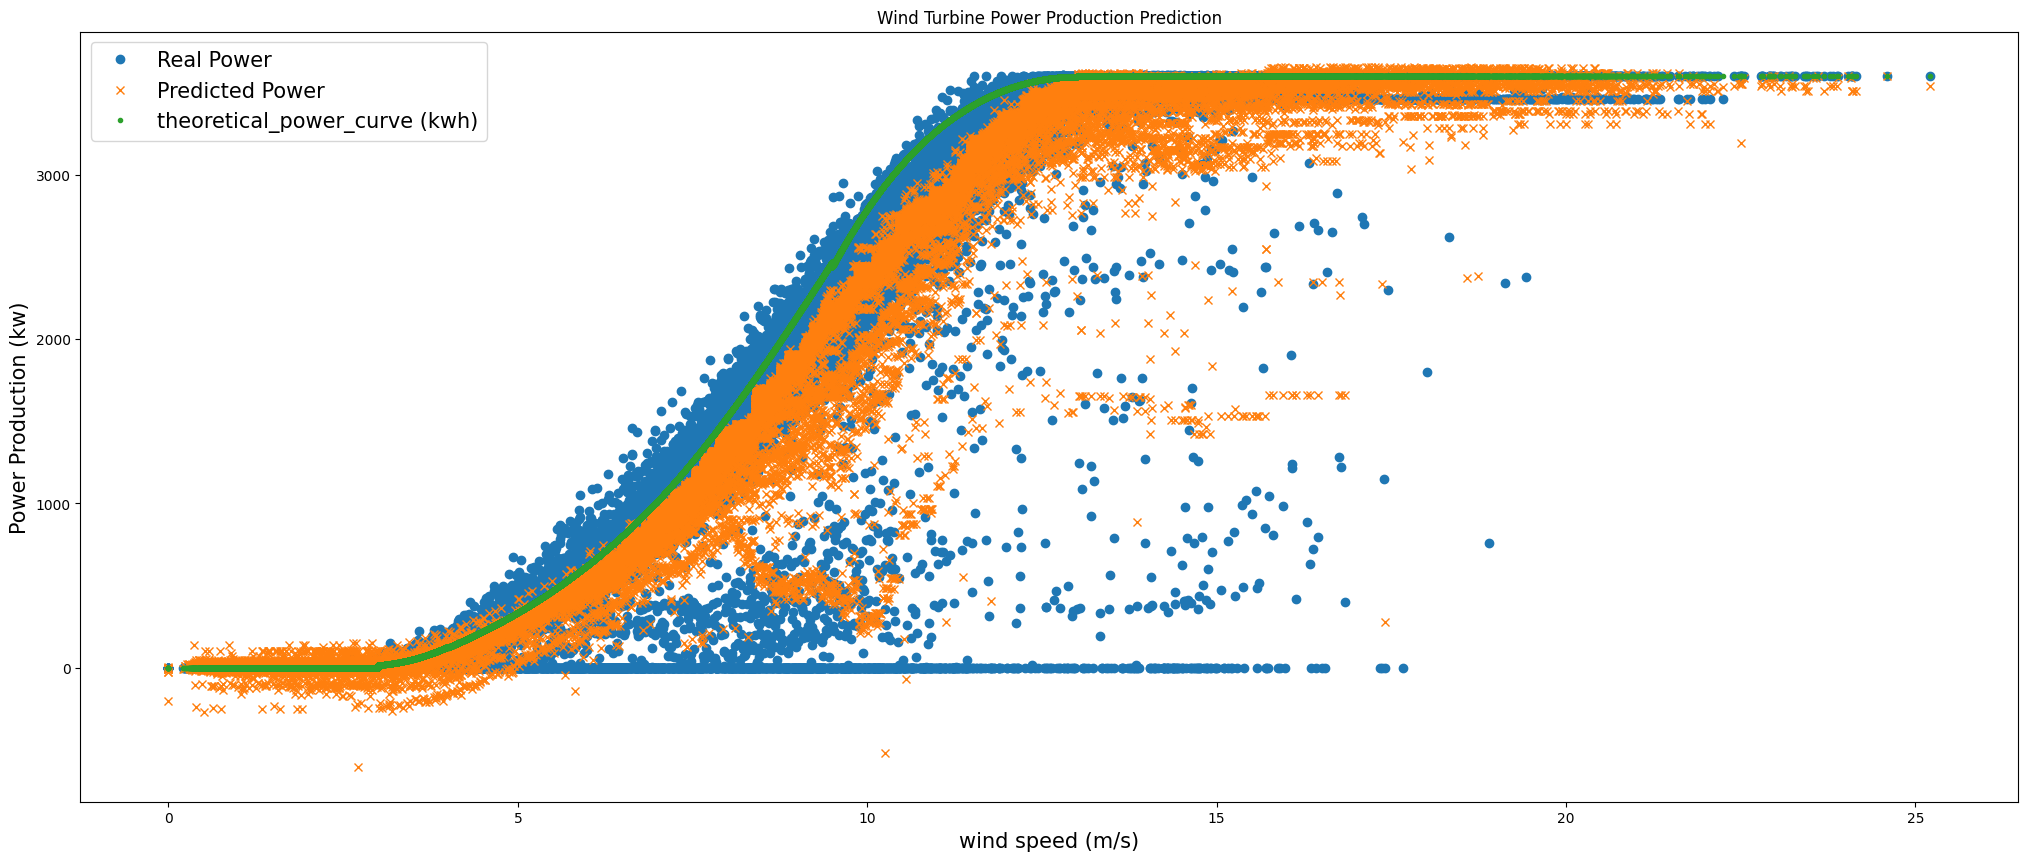

In [ ]:
y_predicted, y_actual = fit_predict_model(GradientBoostingRegressor())
visualise_pred_theor_act(y_actual, y_predicted)

LGBMRegressor

R2 score on the test: 0.9622839091397845
MAE on the test: 105.13419523629551
RMSE on the test: 254.23305020606458


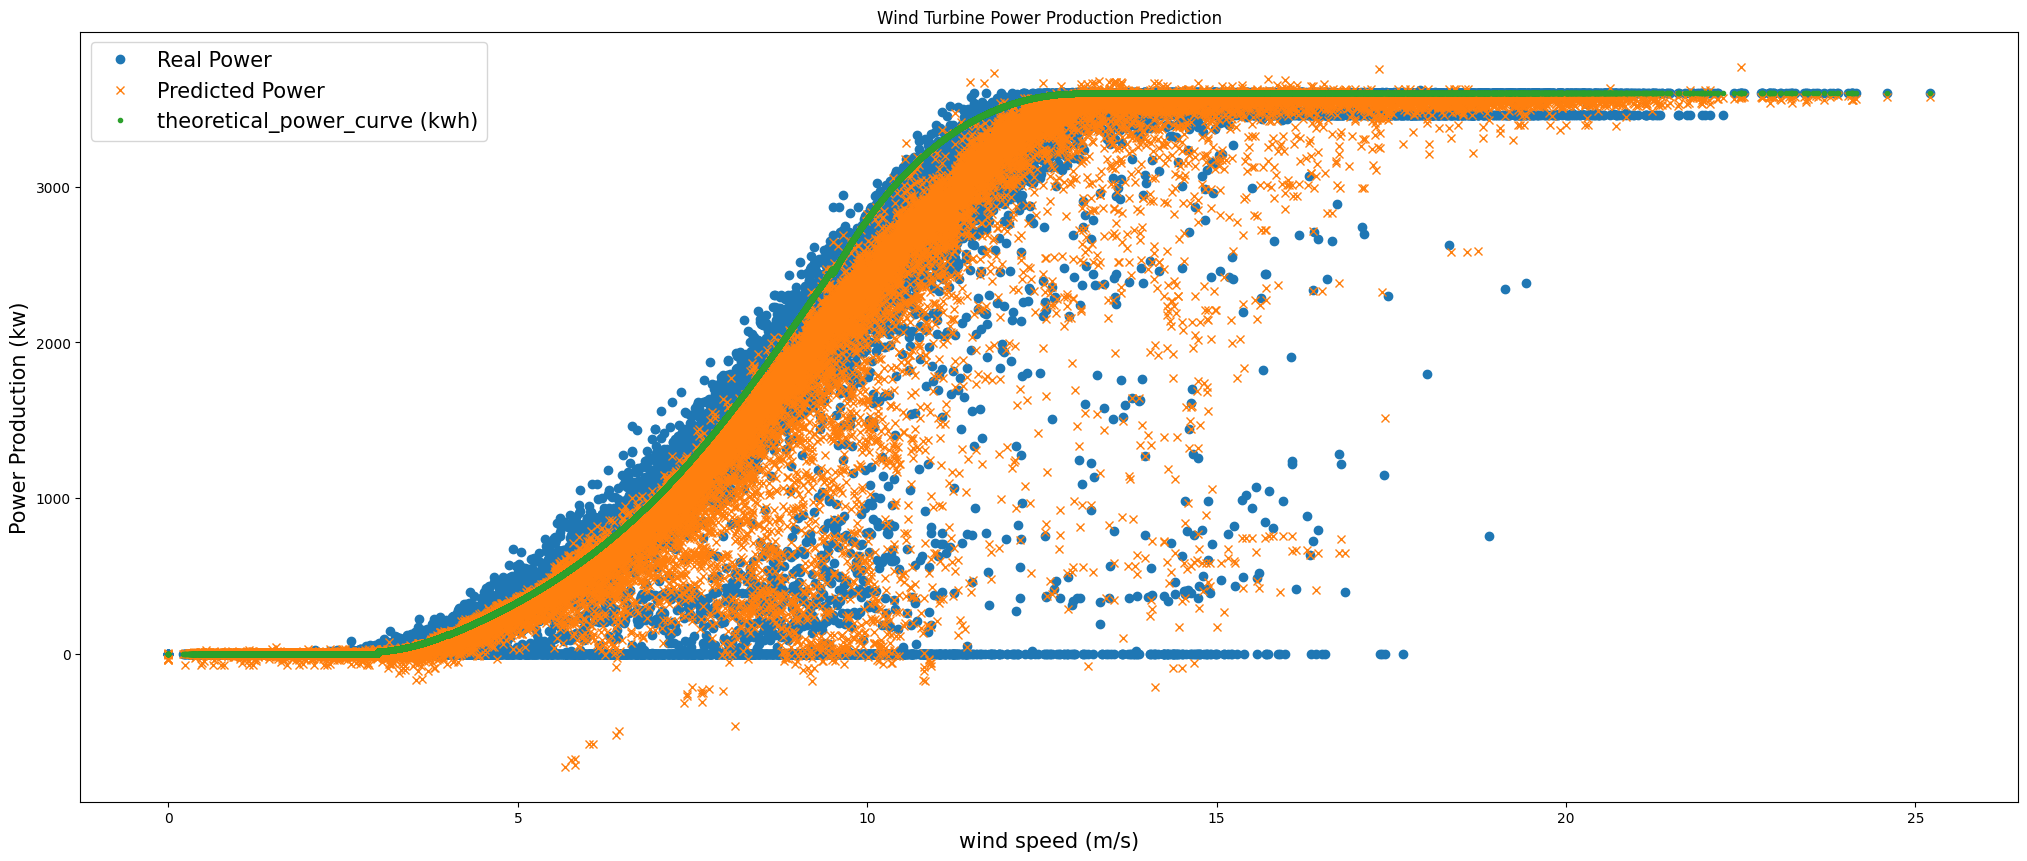

In [ ]:
y_predicted, y_actual = fit_predict_model(lgb.LGBMRegressor())
visualise_pred_theor_act(y_actual, y_predicted)

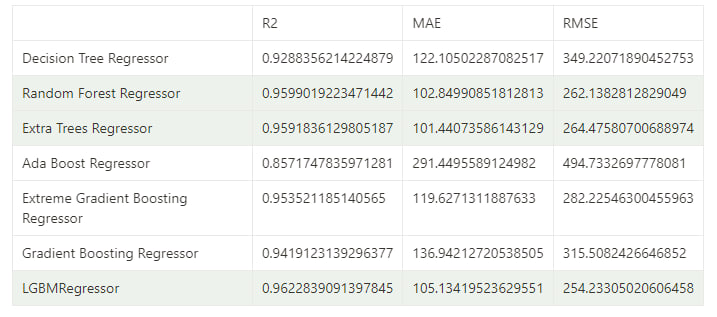

In the project I used algorithms such as Decision Tree Regressor, Random Forest Regressor, Extra Trees Regressor, Ada Boost Regressor, Gradient Boosting Regressor, Extreme Gradient Boosting Regressor (XGBRegressor), LGBMRegressor.

At each model I measured 3 metrics: R Squared Score (R2), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE).

According to the metrics, the best algorithms are LGBMRegressor, Extra Trees Regressor, Random Forest Regressor.
